✅ Loaded meta_grouped.csv for TRAIN: (1570, 6)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1570/1570 [00:21<00:00, 72.41it/s]


🎯 완료 (TRAIN): 저장 1570장, 실패 0장 → /data/ephemeral/home/data/processed/stage0_8_train_v8
✅ TEST 폴더에서 직접 파일 탐색 중...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3140/3140 [00:40<00:00, 78.22it/s]


🎯 완료 (TEST): 저장 3140장, 실패 0장 → /data/ephemeral/home/data/processed/stage0_8_test_v8

📸 그룹별 샘플 2장씩 시각화 (총 6 그룹)


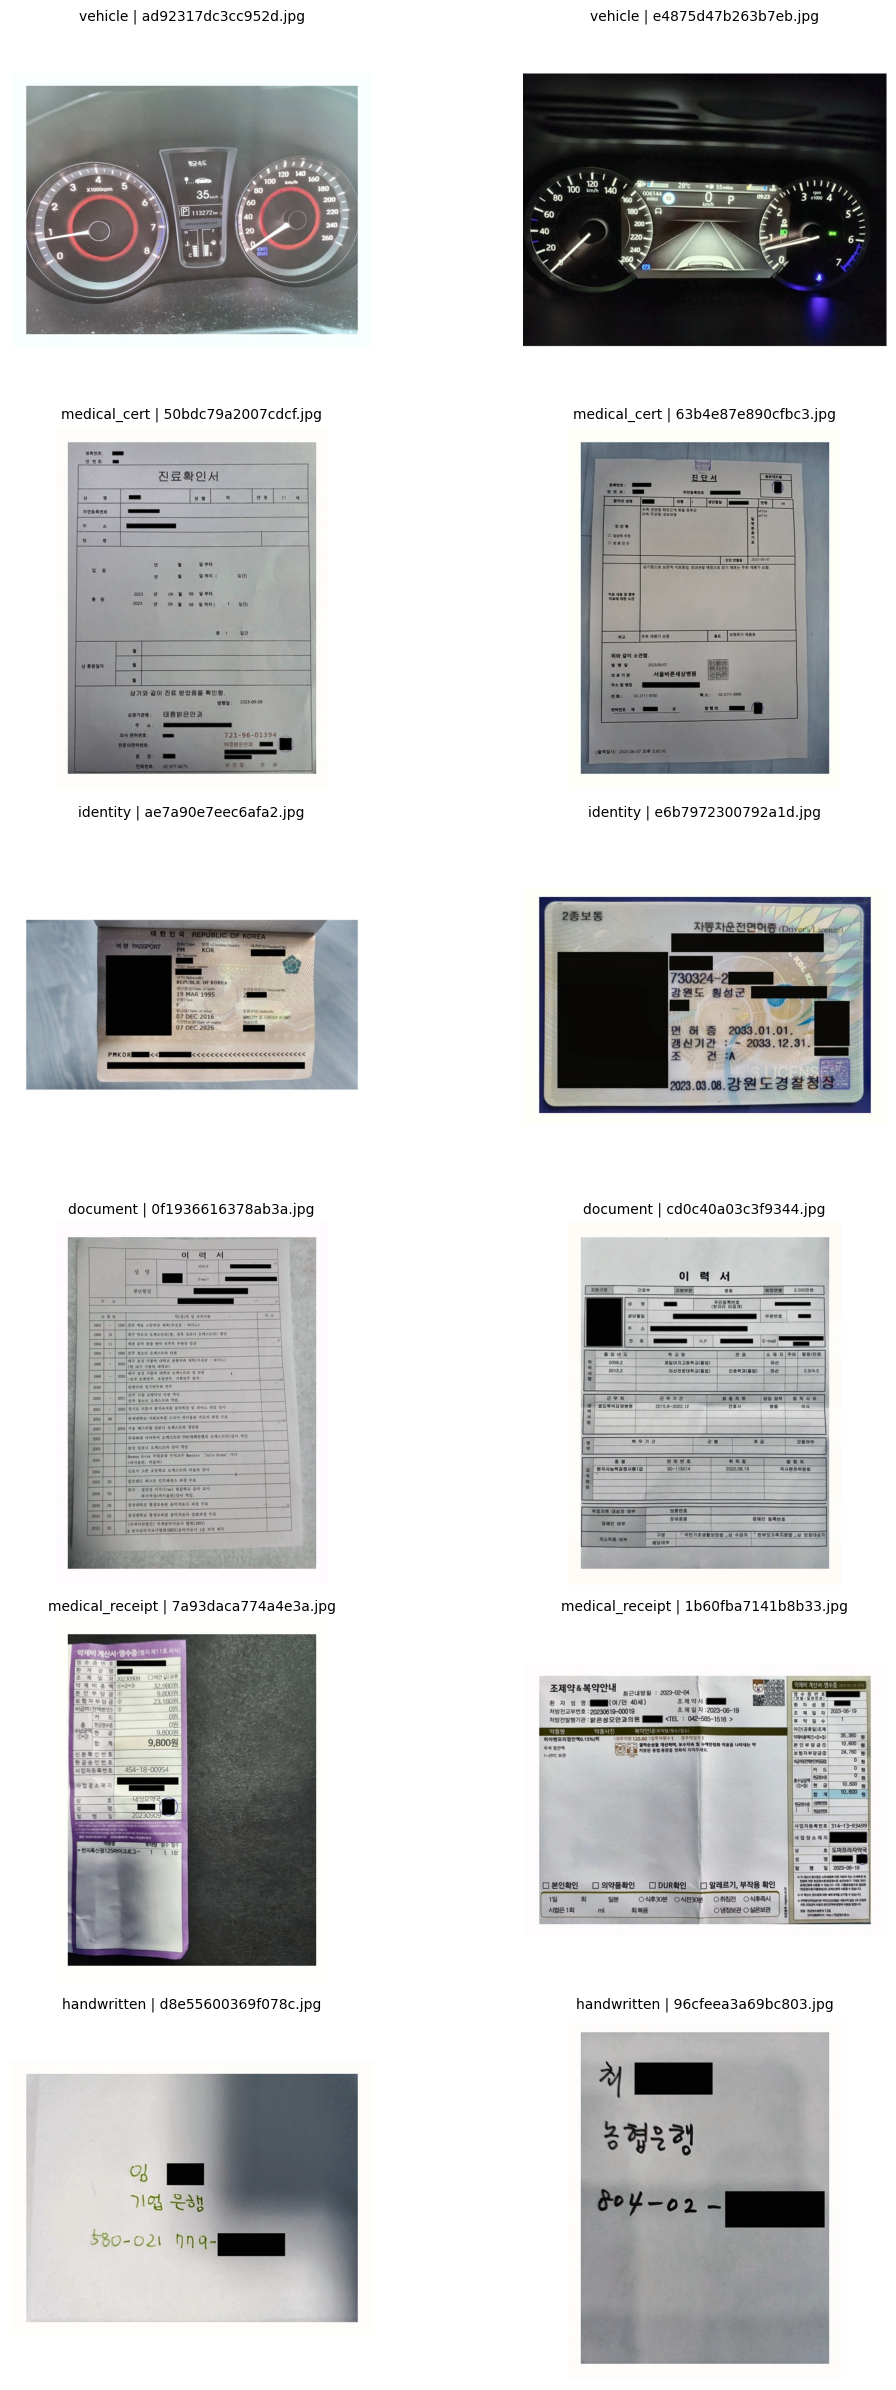

In [1]:
import cv2
import numpy as np
import traceback
import os
import pandas as pd
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import random

# ============================================================
# 🌟 Core Utils
# ============================================================

def resize_with_padding(img, target=768, pad_color=(255, 255, 255)):
    """리사이즈 후 흰색 패딩으로 정사각 정규화"""
    h, w = img.shape[:2]
    s = target / max(h, w)
    nh, nw = int(h * s), int(w * s)
    img = cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA if s < 1 else cv2.INTER_CUBIC)
    top = (target - nh) // 2
    bottom = target - nh - top
    left = (target - nw) // 2
    right = target - nw - left
    return cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=pad_color)


def lap_var(img_gray):
    return cv2.Laplacian(img_gray, cv2.CV_64F).var()

# ============================================================
# 📐 Crop / Padding 보정
# ============================================================

def detect_crop_need(img, edge_thresh=0.10, bright_thresh=0.2):
    """문서가 잘렸는지 감지"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    border_w, border_h = int(w * 0.05), int(h * 0.05)

    edge = cv2.Sobel(gray, cv2.CV_32F, 1, 1, ksize=3)
    edge = np.abs(edge) / 255.0

    outer = edge[:border_h, :].mean() + edge[-border_h:, :].mean() \
           + edge[:, :border_w].mean() + edge[:, -border_w:].mean()
    inner = edge[border_h:-border_h, border_w:-border_w].mean()

    bright_outer = gray[:border_h, :].mean() + gray[-border_h:, :].mean() \
                  + gray[:, :border_w].mean() + gray[:, -border_w:].mean()
    bright_inner = gray[border_h:-border_h, border_w:-border_w].mean()

    edge_gap = max(outer - inner, 0)
    bright_gap = abs(bright_outer - bright_inner) / 255.0

    return (edge_gap > edge_thresh) or (bright_gap > bright_thresh)


def safe_constant_padding(img, pad_ratio=0.05, pad_color=(255,255,255)):
    """조건부 흰색 패딩"""
    h, w = img.shape[:2]
    ph, pw = int(h * pad_ratio), int(w * pad_ratio)
    return cv2.copyMakeBorder(img, ph, ph, pw, pw, cv2.BORDER_CONSTANT, value=pad_color)

# ============================================================
# ☀️ Illumination & Color
# ============================================================

def grayworld_white_balance_soft(img):
    """컬러 균형 완화 버전 (ViT/OCR-friendly)"""
    b, g, r = cv2.split(img.astype(np.float32))
    mean = (b.mean() + g.mean() + r.mean()) / 3.0 + 1e-6
    for ch in [b, g, r]:
        ch *= (mean / (ch.mean() + 1e-6))
    merged = cv2.merge([b, g, r])
    return np.clip(merged, 0, 255).astype(np.uint8)


def lab_equalize_L_contrast(img, clip=1.1, tile=8):
    """LAB 기반 대비 강화 (조정 버전)"""
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile, tile))
    l2 = clahe.apply(l)
    lab = cv2.merge([l2, a, b])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


def apply_gamma_auto(img, base=1.03, max_gamma=1.06):
    """밝기 기반 자동 감마 보정 (완화 버전)"""
    mean = np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) / 255.0
    gamma = np.clip(base + (0.5 - mean) * 0.4, 0.9, max_gamma)
    inv = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(img, table)


def adaptive_unsharp(img, base_sigma=1.2, base_strength=0.18):
    """약한 언샵 (노이즈 안정화 버전)"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lv = lap_var(gray)
    blur_score = np.clip((500.0 - min(lv, 500.0)) / 500.0, 0, 1)
    strength = base_strength * (0.4 + 0.6 * blur_score)
    sigma = base_sigma * (0.8 + 0.7 * blur_score)
    blur = cv2.GaussianBlur(img, (0, 0), sigma)
    sharp = cv2.addWeighted(img, 1 + strength, blur, -strength, 0)
    return np.clip(sharp, 0, 255).astype(np.uint8)

# ============================================================
# 🧩 전체 파이프라인
# ============================================================

def preprocess_image(img, target=768):
    # 1️⃣ 잘림 감지 후 조건부 패딩
    if detect_crop_need(img):
        img = safe_constant_padding(img, pad_ratio=0.05)

    # 2️⃣ 색상 평탄화
    img = grayworld_white_balance_soft(img)

    # 3️⃣ LAB 대비 강화
    img = lab_equalize_L_contrast(img, clip=1.1, tile=8)

    # 4️⃣ 감마 보정 자동화
    img = apply_gamma_auto(img, base=1.03, max_gamma=1.06)

    # 5️⃣ 약한 언샵
    img = adaptive_unsharp(img, base_sigma=1.2, base_strength=0.18)

    # 6️⃣ 정규 리사이즈
    img = resize_with_padding(img, target, pad_color=(255,255,255))
    return img

# ============================================================
# 🧾 실행 함수들
# ============================================================

def run_preprocess(RAW_DIR, SAVE_DIR, META_CSV, OUTPUT_META_PATH, mode):
    os.makedirs(SAVE_DIR, exist_ok=True)
    meta = pd.read_csv(META_CSV)
    meta = meta[meta["group"].notna()]
    print(f"✅ Loaded meta_grouped.csv for {mode.upper()}: {meta.shape}")

    meta["basename"] = meta["filepath"].apply(lambda x: os.path.basename(x).split("_", 1)[-1])
    all_files = glob.glob(os.path.join(RAW_DIR, "**", "*.*"), recursive=True)
    all_basenames = {os.path.basename(f) for f in all_files}
    meta = meta[meta["basename"].isin(all_basenames)].reset_index(drop=True)

    ok, fail = 0, 0
    paths, groups, basenames = [], [], []

    for _, row in tqdm(meta.iterrows(), total=len(meta)):
        base = row["basename"]
        g = row["group"]
        matches = glob.glob(os.path.join(RAW_DIR, "**", base), recursive=True)
        if not matches:
            fail += 1
            continue
        img = cv2.imread(matches[0])
        if img is None:
            fail += 1
            continue
        try:
            out = preprocess_image(img, target=768)
            save_dir_group = os.path.join(SAVE_DIR, g)
            os.makedirs(save_dir_group, exist_ok=True)
            save_path = os.path.join(save_dir_group, base)
            cv2.imwrite(save_path, out)
            paths.append(save_path)
            groups.append(g)
            basenames.append(base)
            ok += 1
        except Exception:
            traceback.print_exc()
            fail += 1

    pd.DataFrame({"filepath": paths, "group": groups, "basename": basenames}).to_csv(OUTPUT_META_PATH, index=False)
    print(f"🎯 완료 ({mode.upper()}): 저장 {ok}장, 실패 {fail}장 → {SAVE_DIR}")

def run_preprocess_test(RAW_DIR, SAVE_DIR, OUTPUT_META_PATH):
    os.makedirs(SAVE_DIR, exist_ok=True)
    print(f"✅ TEST 폴더에서 직접 파일 탐색 중...")
    all_files = glob.glob(os.path.join(RAW_DIR, "**", "*.*"), recursive=True)
    all_files = [f for f in all_files if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    ok, fail = 0, 0
    paths, basenames = [], []

    for fp in tqdm(all_files):
        base = os.path.basename(fp)
        img = cv2.imread(fp)
        if img is None:
            fail += 1
            continue
        try:
            out = preprocess_image(img, target=768)
            save_path = os.path.join(SAVE_DIR, base)
            cv2.imwrite(save_path, out)
            paths.append(save_path)
            basenames.append(base)
            ok += 1
        except Exception:
            traceback.print_exc()
            fail += 1

    pd.DataFrame({"filepath": paths, "basename": basenames}).to_csv(OUTPUT_META_PATH, index=False)
    print(f"🎯 완료 (TEST): 저장 {ok}장, 실패 {fail}장 → {SAVE_DIR}")

# ============================================================
# 📊 그룹별 시각화
# ============================================================

def show_group_samples(meta_csv, n_per_group=2):
    df = pd.read_csv(meta_csv)
    groups = df["group"].unique()
    print(f"\n📸 그룹별 샘플 {n_per_group}장씩 시각화 (총 {len(groups)} 그룹)")

    plt.figure(figsize=(12, 4 * len(groups)))

    for i, g in enumerate(groups):
        subset = df[df["group"] == g].sample(n=min(n_per_group, len(df[df["group"] == g])), random_state=42)
        for j, row in enumerate(subset.itertuples()):
            img = cv2.imread(row.filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(groups), n_per_group, i * n_per_group + j + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{g} | {os.path.basename(row.filepath)}", fontsize=10)

    plt.tight_layout()
    plt.show()

# ============================================================
# 🧠 MAIN
# ============================================================

if __name__ == "__main__":
    BASE = "/data/ephemeral/home/data"
    META = f"{BASE}/interim/meta_grouped.csv"

    run_preprocess(
        RAW_DIR=f"{BASE}/raw/train",
        SAVE_DIR=f"{BASE}/processed/stage0_8_train_v8",
        META_CSV=META,
        OUTPUT_META_PATH=f"{BASE}/meta_stage0_8_train_v8.csv",
        mode="train"
    )

    run_preprocess_test(
        RAW_DIR=f"{BASE}/raw/test",
        SAVE_DIR=f"{BASE}/processed/stage0_8_test_v8",
        OUTPUT_META_PATH=f"{BASE}/meta_stage0_8_test_v8.csv"
    )

    show_group_samples(f"{BASE}/meta_stage0_8_train_v8.csv", n_per_group=2)



🪞 그룹별 원본 vs 보정 비교 (각 2쌍씩)


/tmp/ipykernel_163880/24033858.py:38: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_163880/24033858.py:38: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_163880/24033858.py:38: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_163880/24033858.py:38: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_i

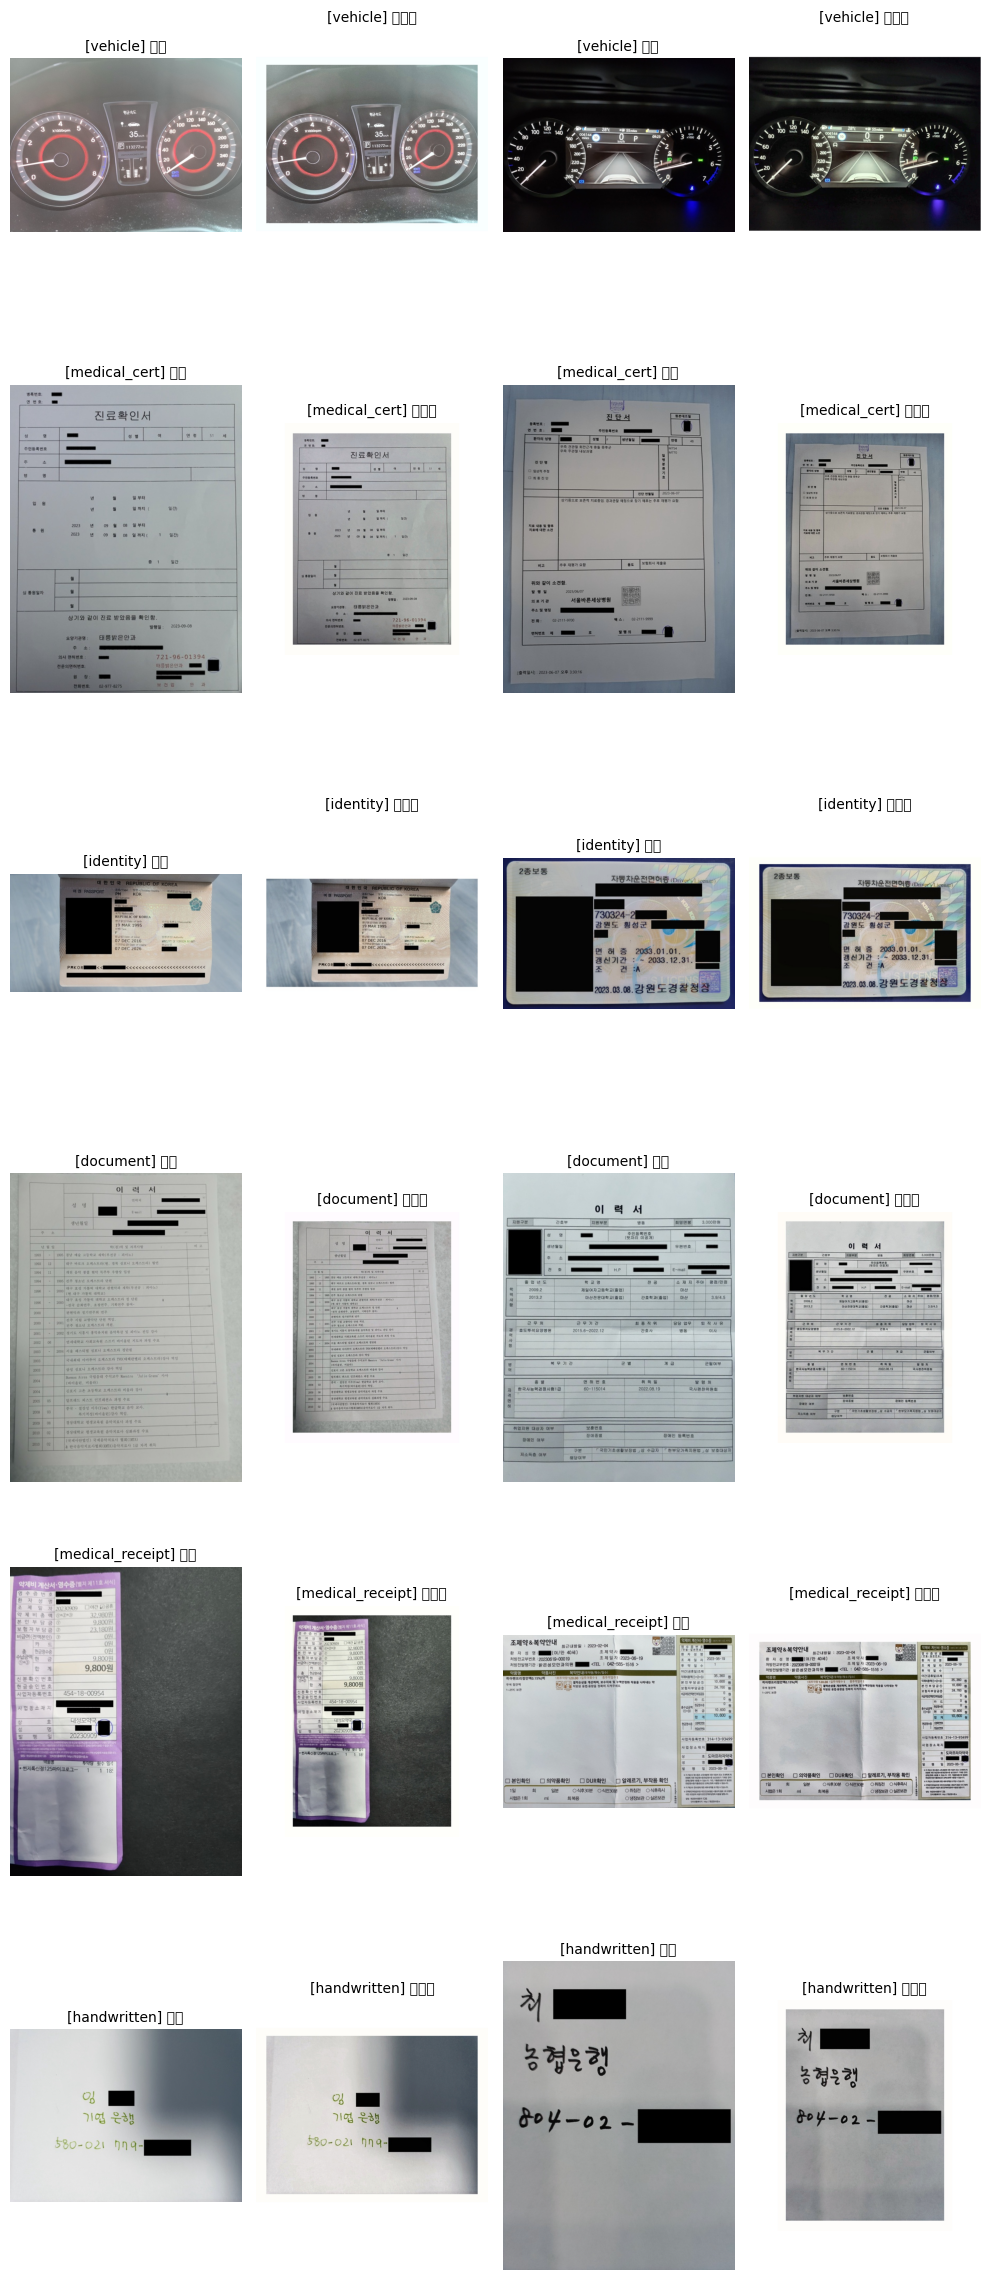

In [2]:
# ============================================================
# 🔍 그룹별 원본 vs 보정 비교 시각화
# ============================================================

def show_group_comparison(meta_csv, raw_dir, n_per_group=2):
    df = pd.read_csv(meta_csv)
    groups = df["group"].unique()
    print(f"\n🪞 그룹별 원본 vs 보정 비교 (각 {n_per_group}쌍씩)")

    plt.figure(figsize=(10, 4 * len(groups)))

    for i, g in enumerate(groups):
        subset = df[df["group"] == g].sample(n=min(n_per_group, len(df[df["group"] == g])), random_state=42)
        for j, row in enumerate(subset.itertuples()):
            # 보정된 이미지
            img_fixed = cv2.imread(row.filepath)
            img_fixed = cv2.cvtColor(img_fixed, cv2.COLOR_BGR2RGB)

            # 원본 이미지 찾기
            base = row.basename
            raw_candidates = glob.glob(os.path.join(raw_dir, "**", base), recursive=True)
            if not raw_candidates:
                continue
            img_raw = cv2.imread(raw_candidates[0])
            img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

            # 좌: 원본 / 우: 보정본
            plt.subplot(len(groups), n_per_group * 2, i * n_per_group * 2 + j * 2 + 1)
            plt.imshow(img_raw)
            plt.axis("off")
            plt.title(f"[{g}] 원본", fontsize=10)

            plt.subplot(len(groups), n_per_group * 2, i * n_per_group * 2 + j * 2 + 2)
            plt.imshow(img_fixed)
            plt.axis("off")
            plt.title(f"[{g}] 보정본", fontsize=10)

    plt.tight_layout()
    plt.show()

# ============================================================
# 🧠 MAIN 내 실행 예시
# ============================================================
if __name__ == "__main__":
    BASE = "/data/ephemeral/home/data"
    META = f"{BASE}/meta_stage0_8_train_v8.csv"
    RAW_TRAIN = f"{BASE}/raw/train"

    if os.path.exists(META):
        show_group_comparison(META, RAW_TRAIN, n_per_group=2)
